In [1]:
%%file detect_pills.py
import cv2
import sys
import numpy as np
import skimage
import itertools
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from tqdm import tqdm
from mpi4py import MPI
from skimage import filters
from skimage import morphology

import matplotlib.pyplot as plt
from skimage import transform as tf
from skimage.measure import label, find_contours
from skimage.feature import match_template
from utils import remove_edges, get_box_of_true_pill, filter_boxes

gallery_path = sys.argv[1]
query_path = sys.argv[2]
output_name = sys.argv[3]
k = int(sys.argv[4])

gallery = cv2.imread(gallery_path)
query = cv2.imread(query_path)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
t_start = MPI.Wtime()

len_points = []
boxes = []

conf_th = 4
confidences = []

query_shape = query.shape
gallery_shape = gallery.shape

step_1 = query_shape[0] // k
step_2 = query_shape[1] // k

ids = list(itertools.product(list(range(0, gallery_shape[0] - query_shape[0], step_1)),
                             list(range(0, gallery_shape[1] - query_shape[1], step_2))))

part_ids = ids[len(ids) // size * rank: len(ids) // size * (rank + 1) if rank != size - 1 else len(ids)]

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(query, None)
index_params = dict(algorithm=1, trees=5)
flann = cv2.FlannBasedMatcher(index_params)

for i, j in part_ids:
    im = gallery[i : query_shape[0] + i, j : query_shape[1] + j]
    try:
        kp2, des2 = sift.detectAndCompute(im,None)

        matches = flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)

        good = [m for m,n in matches if m.distance < 0.7 * n.distance]

        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        len_points.append(len(dst_pts))
        boxes.append([i, j, i + query_shape[0], j + query_shape[1]])

    except Exception:
        continue

len_points = comm.gather(len_points, root=0)
boxes = comm.gather(boxes, root=0)
TIME = comm.gather((MPI.Wtime() - t_start), root=0)
        
if rank == 0:
    print(np.sum(TIME)/size)
    try:
        len_points = np.array(len_points)
        boxes = np.array(boxes)
        res = []
        if len(boxes) > 0:
            final_boxes = filter_boxes(boxes[len_points > 5], len_points[len_points > 5], 0.05)

        img3 = gallery.copy()
        for box in final_boxes:
            img3 = cv2.rectangle(img3, (box[1] , box[0]) , (box[3], box[2]) ,(0, 255, 0), 3)
        cv2.imwrite(output_name, img3)
    except Exception:
        pass

Overwriting detect_pills.py


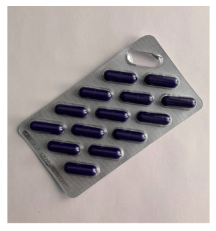

In [6]:
import cv2
import sys
import matplotlib.pyplot as plt
from utils import remove_edges, get_box_of_true_pill

img = cv2.imread('pics/5.png')
plt.imshow(img);

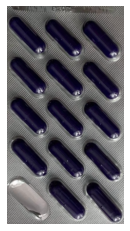

In [7]:
new = remove_edges(img)[20:-20, 20:-20]
plt.imshow(new)
plt.axis('off');

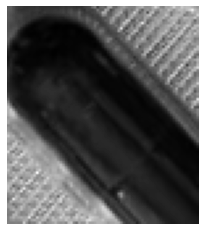

In [8]:
padd = 20
bbox = get_box_of_true_pill(new)
gray = cv2.cvtColor(new.astype('uint8'), cv2.COLOR_BGR2GRAY)

query = gray[bbox[0][1]: bbox[0][3], bbox[0][0]: bbox[0][2]]
gallery = gray.copy()
query = query[padd:-padd, padd:-padd]
cv2.imwrite('query.png', query)
cv2.imwrite('gallery.png', gallery)
plt.imshow(query, 'gray')
plt.axis('off');

In [5]:
time = !mpirun -n 1 python detect_pills.py 'gallery.png' 'query.png' 'res.png' 10
print(time[-1] + ' seconds')

8.313931007 seconds


In [5]:
from tqdm import tqdm
import numpy as np

all_times = []
for i in range(1, 13):
    img = cv2.imread('pics/'+str(i)+'.png')
    new = remove_edges(img)[20:-20, 20:-20]
    
    bbox = get_box_of_true_pill(new)
    gray = cv2.cvtColor(new.astype('uint8'), cv2.COLOR_BGR2GRAY)

    query = gray[bbox[0][1]: bbox[0][3], bbox[0][0]: bbox[0][2]]
    gallery = gray.copy()
    query = query[padd:-padd, padd:-padd]
    cv2.imwrite('query.png', query)
    cv2.imwrite('gallery.png', gallery)
    
    times = []
    for i in tqdm(range(1, 5)):
        time = !mpirun -n {i} python detect_pills.py 'gallery.png' 'query.png' 'res.png'
        times.append(float(time[-1]))
    all_times.append(times)
all_times = np.array(all_times)

100%|█████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]


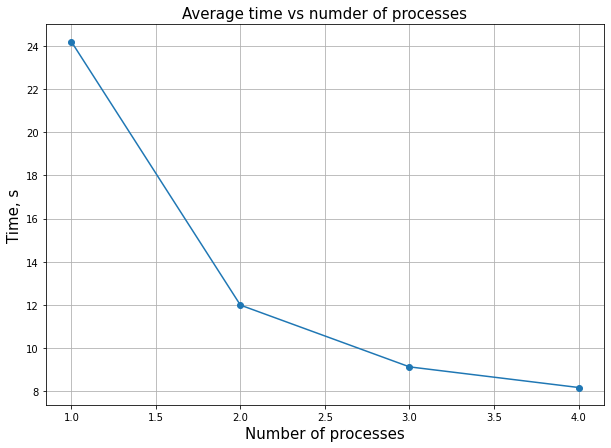

In [6]:
import numpy as np
from matplotlib import pyplot as plt

n_processes = np.array(range(1, 5))
times = np.array(times)

plt.figure(figsize=(10, 7))
plt.plot(n_processes, all_times.mean(axis=0), '-o')
plt.title('Average time vs numder of processes', fontsize=15)
plt.xlabel('Number of processes', fontsize=15)
plt.ylabel('Time, s', fontsize=15)
plt.grid()
plt.show()

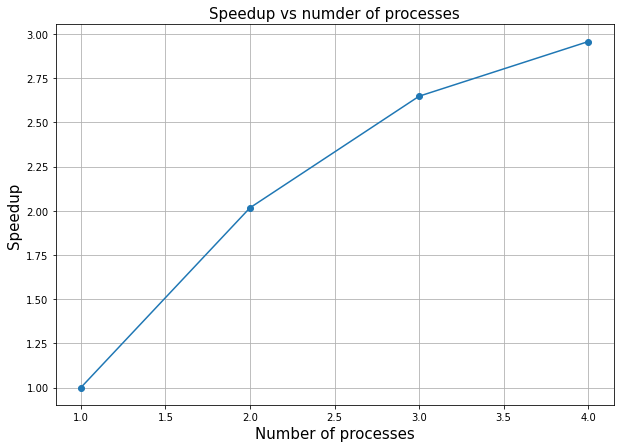

In [7]:
speedups = []
for i in range(len(all_times)):
    speedup = all_times[i][0] / all_times[i]
    speedups.append(speedup)
speedups = np.array(speedups)

plt.figure(figsize=(10, 7))
plt.plot(n_processes, speedups.mean(axis=0), '-o')
plt.title('Speedup vs numder of processes', fontsize=15)
plt.xlabel('Number of processes', fontsize=15)
plt.ylabel('Speedup', fontsize=15)
plt.grid()
plt.show()